# Challenge
Task Description
Use the information provided in the attached file to compute the breathing rate at 15-second intervals.
- Do not use any external packages that directly calculate breathing rate. It is acceptable to use libraries such as NumPy, scikit-learn (sklearn), etc.
- The input file contains up to three fields per entry:
  -	ts: timestamp (always present)
  -	hr: heart rate
  -	rr: a list of inter-beat intervals
Output Requirements
- Generate a CSV file with two columns:
  - time: formatted as HH:MM:SS, localized to the PDT timezone
  - bpm: breaths per minute, rounded to 1 decimal place
Additional Requirements
- Provide a standalone Python script that can be executed to regenerate the output.
- The code should be well-documented to clearly explain your logic and methodology.


# Solution

Let's start by loading the file

In [1]:
import json
import pandas as pd

# Parse the JSON file
with open('H10_log_20250611_2133.json', 'r') as file:
    data = json.load(file)

# Create pandas DataFrame
df = pd.DataFrame(data)

# Convert timestamp to datetime and localize to PDT
df['datetime'] = pd.to_datetime(df['ts'], unit='s', utc=True).dt.tz_convert('US/Pacific')
df['time'] = df['datetime'].dt.strftime('%H:%M:%S')

print(df[['time', 'hr', 'rr']].head())
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

       time  hr          rr
0  20:41:00  76       [791]
1  20:41:00  76       [755]
2  20:41:01  77  [751, 747]
3  20:41:03  77       [759]
4  20:41:03  77       [773]

DataFrame shape: (3120, 5)

Columns: ['ts', 'hr', 'rr', 'datetime', 'time']


In [2]:
df['datetime'][0]

Timestamp('2025-06-11 20:41:00.008299828-0700', tz='US/Pacific')

As a sanity check let's confirm that this is actually the same unix timestamp received in the first row of the json

In [3]:
# Verify timestamp conversion
original_timestamp = data[0]['ts']
converted_timestamp = df['datetime'][0].timestamp()

print(f"Original timestamp: {original_timestamp}")
print(f"Converted back timestamp: {converted_timestamp}")
print(f"Difference: {abs(original_timestamp - converted_timestamp)}")
print(f"Match: {abs(original_timestamp - converted_timestamp) < 1e-6}")

# Also show the formatted time for verification
print(f"\nFirst entry time (PDT): {df['time'][0]}")
print(f"First entry datetime: {df['datetime'][0]}")

Original timestamp: 1749699660.0082998
Converted back timestamp: 1749699660.0083
Difference: 2.384185791015625e-07
Match: True

First entry time (PDT): 20:41:00
First entry datetime: 2025-06-11 20:41:00.008299828-07:00


Now we need to compute the Breaths Per Minute. This is an interesting metric that can, sometimes, be derived from the RR intervals or Heart Rate itself. The underlying logic is that, as we breath, the diafragma compresses and uncompresses the heart cavity, effectively changing the heart rate in a regular pattern. Before doing anything we need to plot the HR and RR to see if we have a good signal

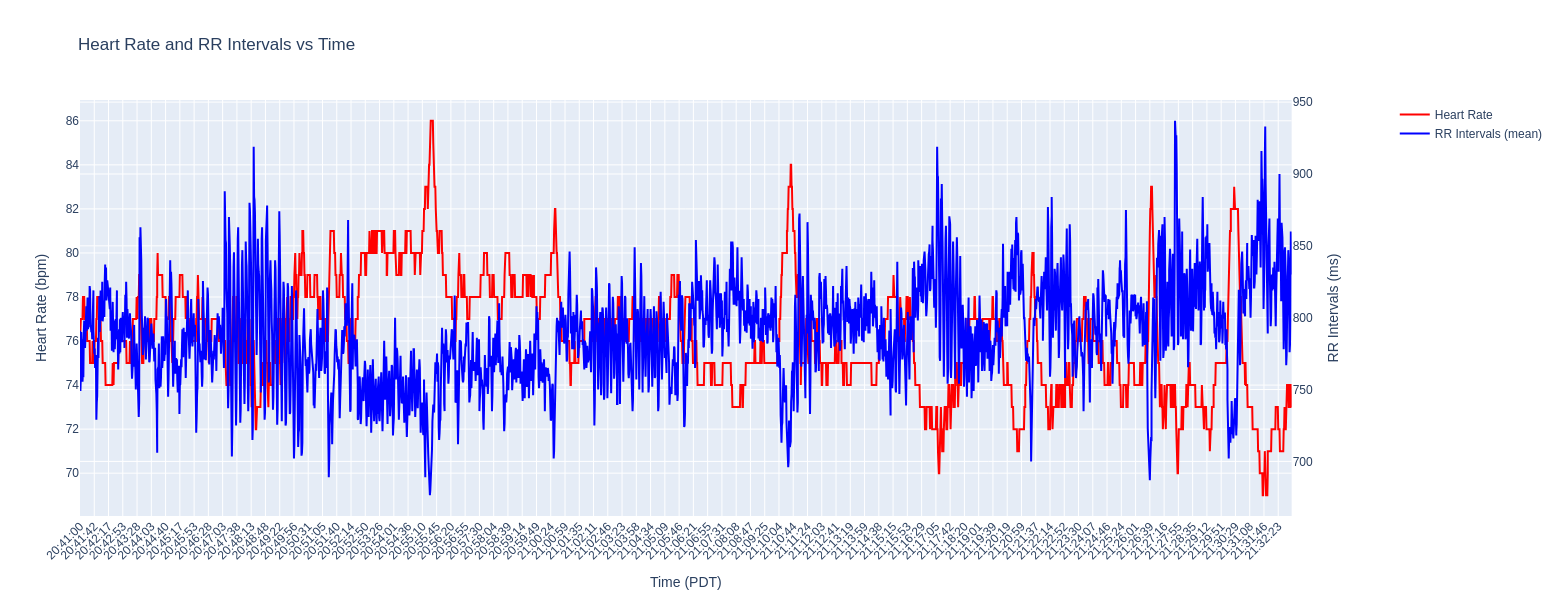

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Calculate mean RR interval for each timestamp
df['rr_mean'] = df['rr'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)

# Create subplot with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add HR trace
fig.add_trace(
    go.Scatter(x=df['time'], y=df['hr'], 
               name="Heart Rate", 
               line=dict(color="red")),
    secondary_y=False,
)

# Add RR mean trace
fig.add_trace(
    go.Scatter(x=df['time'], y=df['rr_mean'], 
               name="RR Intervals (mean)", 
               line=dict(color="blue")),
    secondary_y=True,
)

# Set y-axes titles
fig.update_yaxes(title_text="Heart Rate (bpm)", secondary_y=False)
fig.update_yaxes(title_text="RR Intervals (ms)", secondary_y=True)

# Set x-axis title
fig.update_xaxes(title_text="Time (PDT)")

# Update layout
fig.update_layout(
    title="Heart Rate and RR Intervals vs Time",
    xaxis_tickangle=-45,
    height=600
)

fig.show()

Notice that we can turn on/off signals in the chart above by clicking in the correspondent tick on the top right. Zooming in we can see that we have parts of the RR signal that have a regular pattern likely due to breathing, so we will try to compute the Breath Per Minute metric by finding peaks on this signal.

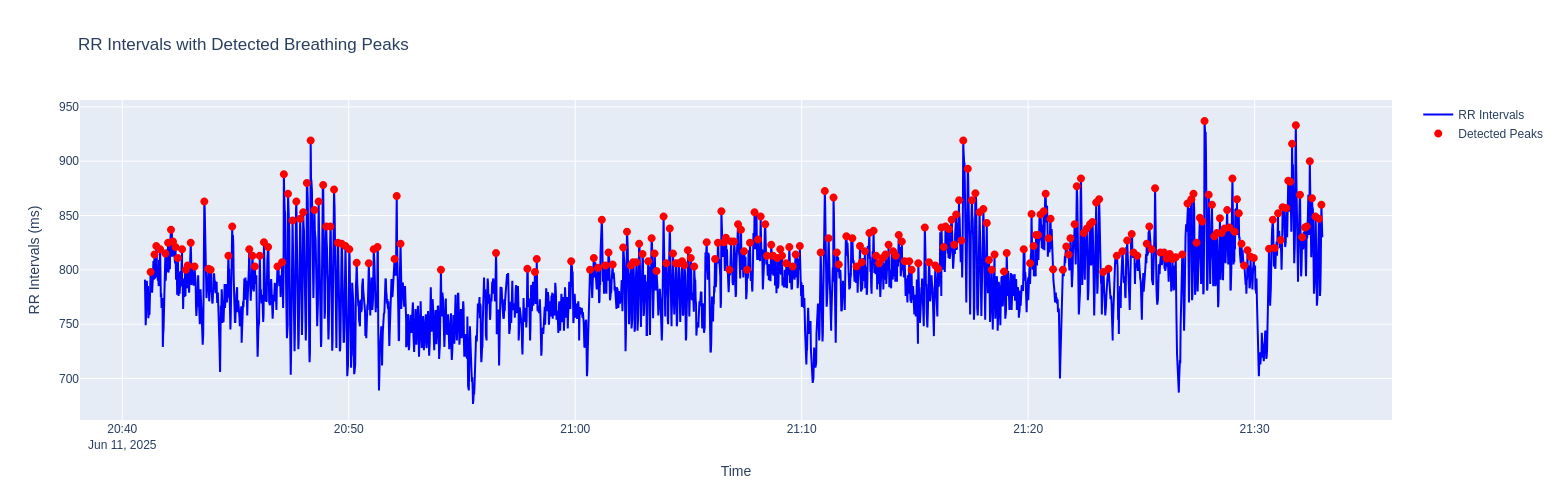

In [43]:
import numpy as np
from scipy.signal import find_peaks
import plotly.graph_objects as go

# Remove NaN values and get clean RR data
clean_mask = df['rr_mean'].notna()
clean_rr = df['rr_mean'][clean_mask].values
clean_time = df['datetime'][clean_mask]

# Find peaks in the RR signal
# Adjust height and distance parameters as needed
peaks, properties = find_peaks(clean_rr, 
                              height=np.percentile(clean_rr, 60),  # Only peaks above 60th percentile
                              distance=5)  # Minimum 20 samples between peaks

# Calculate time intervals between peaks (in seconds)
peak_times = clean_time.iloc[peaks]
time_intervals = np.diff(peak_times).astype('timedelta64[s]').astype(float)

# Convert to breaths per minute
breaths_per_minute = 60 / time_intervals

# Create visualization
fig = go.Figure()

# Plot RR signal
fig.add_trace(go.Scatter(
    x=clean_time, 
    y=clean_rr,
    mode='lines',
    name='RR Intervals',
    line=dict(color='blue')
))

# Plot detected peaks
fig.add_trace(go.Scatter(
    x=peak_times,
    y=clean_rr[peaks],
    mode='markers',
    name='Detected Peaks',
    marker=dict(color='red', size=8)
))

fig.update_layout(
    title='RR Intervals with Detected Breathing Peaks',
    xaxis_title='Time',
    yaxis_title='RR Intervals (ms)',
    height=500
)

fig.show()


Now we can try to find the distance between the peaks to finally find the Breath Per Minute. There are a lot of bad peaks therefore peak diffs that won't correspond with an actual breath, so we should cutoff those.

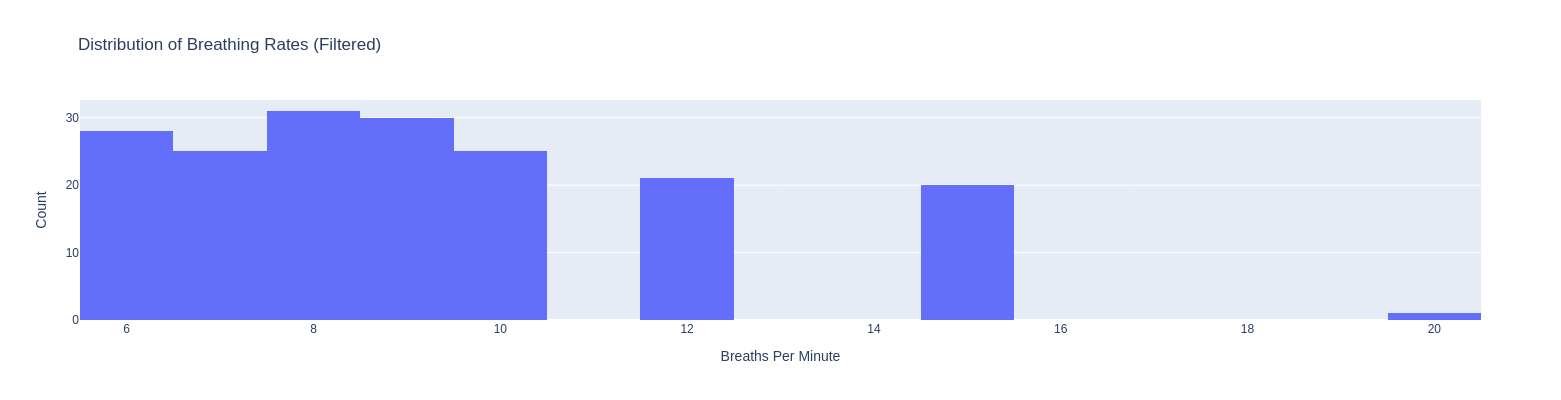

Original peaks detected: 257
Valid breathing intervals: 181
Filtered out: 76 intervals

Filtered Breathing Rate Statistics:
Average: 9.1 breaths/min
Median: 8.6 breaths/min
Range: 6.0 - 20.0 breaths/min
Standard deviation: 2.9 breaths/min

Time intervals (seconds):
Average: 7.2s
Range: 3.0 - 10.0s


In [48]:
# Calculate time differences between consecutive peaks
peak_time_diffs = np.diff(peak_times).astype('timedelta64[s]').astype(float)

# Filter out unrealistic breathing intervals
min_interval = 2
max_interval = 10

# Filter the intervals
valid_intervals = peak_time_diffs[(peak_time_diffs >= min_interval) & 
                                 (peak_time_diffs <= max_interval)]

# Convert to breaths per minute
valid_bpm = 60 / valid_intervals

# Create histogram of breathing rates centered on integers
bin_start = int(np.floor(np.min(valid_bpm))) - 0.5
bin_end = int(np.ceil(np.max(valid_bpm))) + 0.5
bin_size = 1.0

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=valid_bpm,
    xbins=dict(start=bin_start, end=bin_end, size=bin_size),
    name="Breathing Rate Distribution"
))
fig.update_layout(
    title='Distribution of Breathing Rates (Filtered)',
    xaxis_title='Breaths Per Minute',
    yaxis_title='Count',
    height=400
)

fig.show()

# Print statistics
print(f"Original peaks detected: {len(peak_time_diffs)}")
print(f"Valid breathing intervals: {len(valid_intervals)}")
print(f"Filtered out: {len(peak_time_diffs) - len(valid_intervals)} intervals")
print(f"\nFiltered Breathing Rate Statistics:")
print(f"Average: {np.mean(valid_bpm):.1f} breaths/min")
print(f"Median: {np.median(valid_bpm):.1f} breaths/min")
print(f"Range: {np.min(valid_bpm):.1f} - {np.max(valid_bpm):.1f} breaths/min")
print(f"Standard deviation: {np.std(valid_bpm):.1f} breaths/min")

# Show time intervals for validation
print(f"\nTime intervals (seconds):")
print(f"Average: {np.mean(valid_intervals):.1f}s")
print(f"Range: {np.min(valid_intervals):.1f} - {np.max(valid_intervals):.1f}s")